In [1]:
import os
import time
import random
import xml.etree.ElementTree as ET

import cv2
import numpy as np

import torch

from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

import matplotlib.pyplot as plt

## Hyper-Params & Utils

In [2]:
WIDER_CLASSES = ('__background__', 'face')

batch_size = 16

In [3]:
class AnnotationTransform(object):
    def __init__(self, class_to_ind=None, keep_difficult=True, norm=True):
        self.class_to_ind = class_to_ind or dict(
            zip(WIDER_CLASSES, range(len(WIDER_CLASSES))))
        self.keep_difficult = keep_difficult
        self.norm = norm

    def __call__(self, target):
        res = np.empty((0, 15))

        size = target.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        for obj in target.iter('object'):
            difficult = int(obj.find('difficult').text) == 1
            if not self.keep_difficult and difficult:
                continue
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            # has_lm = int(obj.find('has_lm').text)

            # get face rect
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            bndbox = []
            for i, pt in enumerate(pts):
                cur_pt = int(bbox.find(pt).text)
                bndbox.append(cur_pt)

            # get face landmark
            if int(obj.find('has_lm').text.strip()) == 1:
                lm = obj.find('lm')
                pts = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5']
                for i, pt in enumerate(pts):
                    xy_value = float(lm.find(pt).text)
                    bndbox.append(xy_value)
            else:  # append 10 zeros
                for i in range(10):
                    bndbox.append(0)

            # normalize xy
            if self.norm:
                bndbox = [coord/width if idx%2==0 else coord/height for idx,coord in enumerate(bndbox)]
            
            # label 0 or 1 (bk or face)
            label_idx = self.class_to_ind[name]
            bndbox.append(label_idx)

            res = np.vstack(
                (res, bndbox))  # [xmin, ymin, xmax, ymax, x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, w, h, label_ind]
        return res

In [4]:
def denorm(coords, shape):
    coords[:, 0::2] = coords[:, 0::2] * shape[0]
    coords[:, 1::2] = coords[:, 1::2] * shape[1]

In [5]:
def draw(img: np.ndarray, bboxes: np.ndarray, landmarks: np.ndarray=None, scores: np.ndarray=None) -> np.ndarray:
    '''
    This function draws bounding boxes and landmarks on the image and return the result.
    
    Parameters:
        bboxes    - bboxes of shape [n, 5]. 'n' for number of bboxes, '5' for coordinate and confidence 
                    (x1, y1, x2, y2, c).
        landmarks - landmarks of shape [n, 5, 2]. 'n' for number of bboxes, '5' for 5 landmarks
                    (two for eyes center, one for nose tip, two for mouth corners), '2' for coordinate
                    on the image.
    Returns:
        img       - image with bounding boxes and landmarks drawn
    '''

    # convert BGR to RGB for correct color display
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # draw bounding boxes
    if bboxes is not None:
        color = (0, 255, 0)
        thickness = 2
        for idx in range(bboxes.shape[0]):
            bbox = bboxes[idx].astype(np.int)
            cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)
            if scores:
                cv2.putText(img, '{:.4f}'.format(scores[idx]), (bbox[0], bbox[1]+12), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

    # draw landmarks
    if landmarks is not None:
        radius = 2
        thickness = 2
        color = [(255, 0, 0), (0, 0, 255), (0, 255, 255), (255, 255, 0), (0, 255, 0)]
        for idx in range(landmarks.shape[0]):
            face_landmarks = landmarks[idx].astype(np.int)
            for idx, landmark in enumerate(face_landmarks):
                cv2.circle(img, (int(landmark[0]), int(landmark[1])), radius, color[idx], thickness)
    return img

# Official DALI

## Defining the data source

In [6]:
class WIDERFaceIterator(object):
    def __init__(self, root_dir, anno_transformer=AnnotationTransform(), batch_size=16):
        self.root = root_dir
        self.anno_transformer = anno_transformer
        self.batch_size = batch_size
        
        self.ids = list()
        with open(os.path.join(self.root, 'img_list.wf.txt'), 'r') as f:
            self.ids = [tuple(line.split()) for line in f]

    def __len__(self):
        return len(self.ids)
            
    def __iter__(self):
        self.i = 0
        self.n = len(self.ids)
        return self

    def __next__(self):
        img = list()
        bbox = list()
        lm = list()
        label = list()
        for _ in range(self.batch_size):
            jpg_filename, anno_filename = self.ids[self.i]

            # read images
            jpg_fhandler = open(os.path.join(self.root, jpg_filename), 'rb')
            img.append(
                np.frombuffer(jpg_fhandler.read(), dtype=np.uint8)
            )

            # read ground truths (bbox+landmark) and cls
            anno = self.anno_transformer(
                ET.parse(os.path.join(self.root, anno_filename)).getroot()
            )
            bbox.append(
                np.ascontiguousarray(anno[:, :4], dtype=np.float32)
            )
            lm.append(
                np.ascontiguousarray(anno[:, 4:-1], dtype=np.float32)
            )
            label.append(
                np.ascontiguousarray(anno[:, -1], dtype=np.int32)
            )

            self.i = (self.i + 1) % self.n
        return (img, bbox, lm, label)

## RandomBBoxCrop Pipeline

In [7]:
# define the pipeline
class CropPipeline(Pipeline):
    def __init__(self, source_iterator, batch_size=16, num_threads=2, device_id=0):
        super(CropPipeline, self).__init__(batch_size, num_threads, device_id, seed=12)
        self.source = ops.ExternalSource(source=source_iterator, num_outputs=4)
        self.decode = ops.ImageDecoder(device='cpu', output_type=types.RGB)
        # Data augmentation
        self.crop = ops.RandomBBoxCrop(
            device="cpu",
            aspect_ratio=[0.5, 2.0],
            scaling=[0.3, 1.0],
            thresholds=[1.0],
            threshold_type='overlap',
            all_boxes_above_threshold=False,
            bbox_layout="xyXY",
            allow_no_crop=True,
            num_attempts=1,
            total_num_attempts=250
        )
        self.slice = ops.Slice(device='cpu')
        
    def define_graph(self):
        jpgs, bboxes, lms, labels = self.source()
        imgs = self.decode(jpgs)

        crop_begin, crop_size, bboxes_, labels_ = self.crop(bboxes, labels)
        imgs_ = self.slice(imgs, crop_begin, crop_size)

        return (imgs_, bboxes_, labels_, imgs, bboxes, lms, labels)

## Test

In [8]:
# use the pipeline
wfi = WIDERFaceIterator('./WIDER_FACE_rect')
pipe = CropPipeline(wfi)
pipe.build()
start = time.time()
pipe_out = pipe.run()
end = time.time()
print(end-start)

0.3194725513458252


In [9]:
cropped_img = pipe_out[0]
cropped_bbx = pipe_out[1]
cropped_label = pipe_out[2]

ori_img = pipe_out[3]
ori_bbx = pipe_out[4]
ori_lm  = pipe_out[5]
ori_label = pipe_out[6]

(14, 4)
(880, 774)
(19, 4)
(807, 1024, 3)


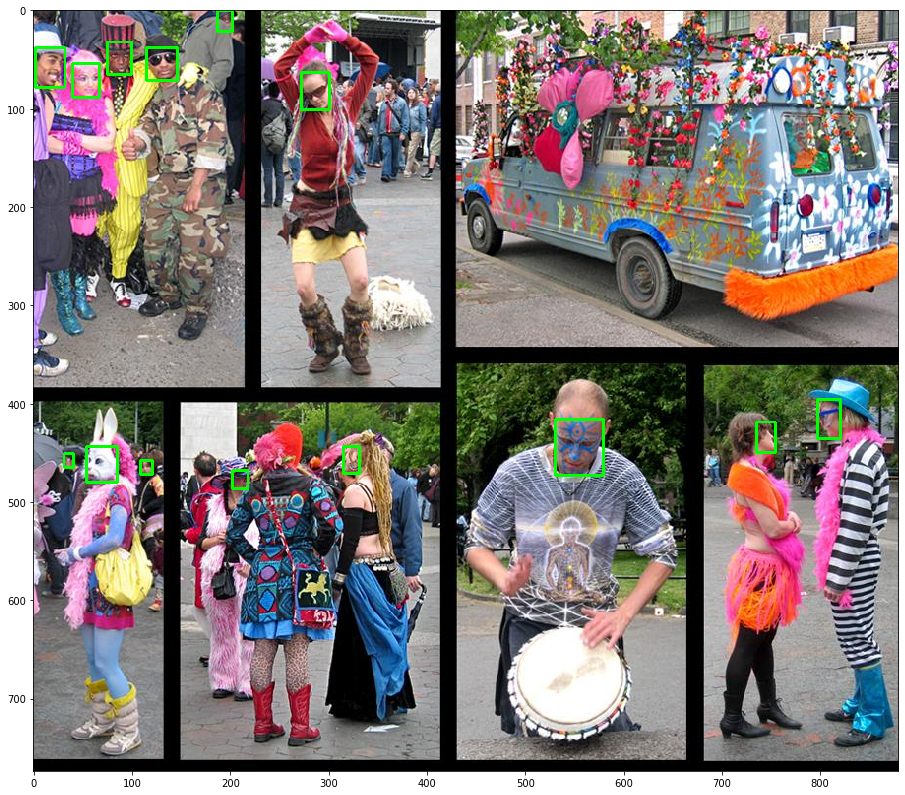

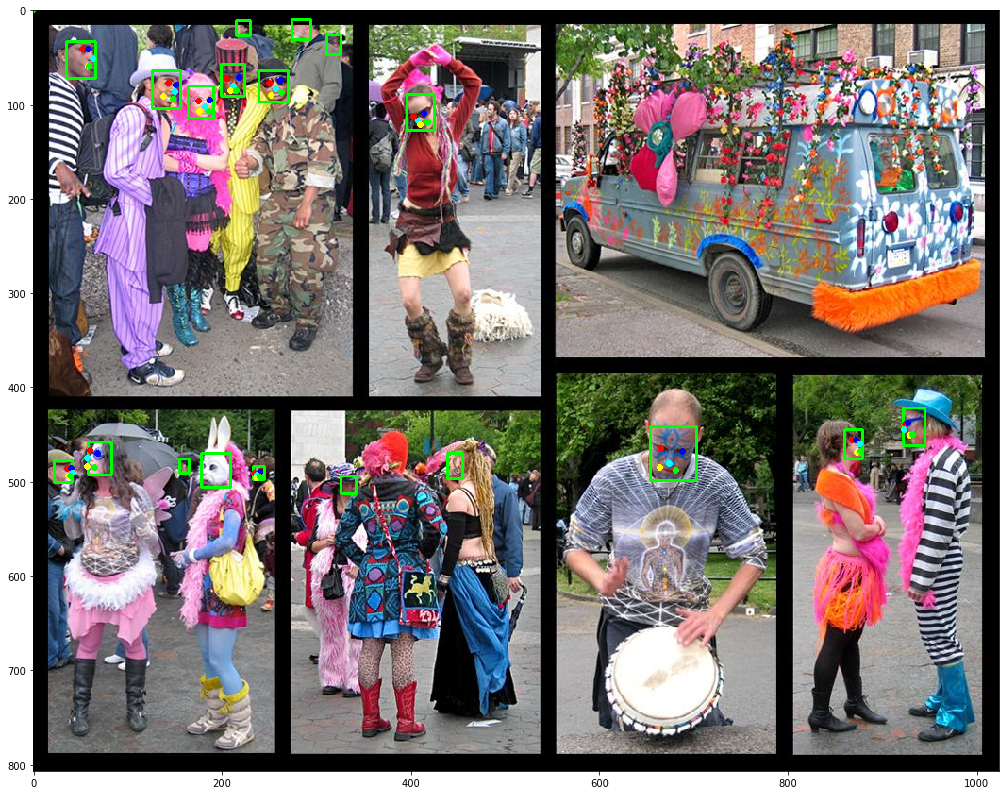

In [10]:
idx = random.randrange(batch_size)

cimg = cropped_img.at(idx)
cbbx = cropped_bbx.at(idx)
clabel = cropped_label.at(idx)
denorm(cbbx, (cimg.shape[1], cimg.shape[0]))
print(cbbx.shape)
print((cimg.shape[1], cimg.shape[0]))
plt.figure(figsize = (20,14))
plt.imshow(draw(cimg, cbbx))

oimg = ori_img.at(idx)
obbx = ori_bbx.at(idx)
olm = ori_lm.at(idx)
olabel = ori_label.at(idx)
denorm(obbx, (oimg.shape[1], oimg.shape[0]))
denorm(olm, (oimg.shape[1], oimg.shape[0]))
print(obbx.shape)
print(oimg.shape)
plt.figure(figsize = (20,14))
plt.imshow(draw(oimg, obbx, np.reshape(olm, (-1, 5, 2))))


## DALI plugin - My Impl

In [12]:
import nvidia.dali.plugin_manager as plugin_manager
plugin_manager.load_library('/home/tau/projects/DALI_plugins/build/libExtendRandomBBoxCrop.so')

In [13]:
class MyCropPipeline(Pipeline):
    def __init__(self, source_iterator, batch_size=16, num_threads=2, device_id=0):
        super(MyCropPipeline, self).__init__(batch_size, num_threads, device_id, seed=12)
        self.source = ops.ExternalSource(source=source_iterator, num_outputs=4)
        self.decode = ops.ImageDecoder(device='cpu', output_type=types.RGB)
        # Data augmentation
        self.crop = ops.ExtendRandomBBoxCrop(
            device="cpu",
            aspect_ratio=[0.5, 2.0],
            scaling=[0.3, 1.0],
            thresholds=[1.0],
            threshold_type='overlap',
            all_boxes_above_threshold=False,
            bbox_layout="xyXY",
            allow_no_crop=True,
            num_attempts=1,
            total_num_attempts=250
        )
        self.slice = ops.Slice(device='cpu')
        
    def define_graph(self):
        jpgs, bboxes, lms, labels = self.source()
        imgs = self.decode(jpgs)

        crop_begin, crop_size, bboxes_, lms_, labels_ = self.crop(bboxes, lms, labels)
#         imgs_ = self.slice(imgs, crop_begin, crop_size)

#         return (imgs_, bboxes_, lms_, labels_, imgs, bboxes, lms, labels)
        return (imgs, bboxes, labels)

## Test

In [14]:
# use the pipeline
wfi1 = WIDERFaceIterator('./WIDER_FACE_rect')
mypipe = MyCropPipeline(wfi1)
mypipe.build()
start = time.time()
mypipe_out = mypipe.run()
end = time.time()
print(end-start)

RuntimeError: [/opt/dali/dali/pipeline/pipeline.h:174] Cannot find __ExternalSource_9 tensor, it doesn't exists or was pruned as unused one.
Stacktrace (100 entries):
[frame 0]: /home/tau/anaconda3/lib/python3.7/site-packages/nvidia/dali/backend_impl.cpython-37m-x86_64-linux-gnu.so(+0x22e56) [0x7fd5d3e86e56]
[frame 1]: /home/tau/anaconda3/lib/python3.7/site-packages/nvidia/dali/backend_impl.cpython-37m-x86_64-linux-gnu.so(+0x746eb) [0x7fd5d3ed86eb]
[frame 2]: /home/tau/anaconda3/lib/python3.7/site-packages/nvidia/dali/backend_impl.cpython-37m-x86_64-linux-gnu.so(+0x44df6) [0x7fd5d3ea8df6]
[frame 3]: /home/tau/anaconda3/lib/python3.7/site-packages/nvidia/dali/backend_impl.cpython-37m-x86_64-linux-gnu.so(+0x59943) [0x7fd5d3ebd943]
[frame 4]: /home/tau/anaconda3/bin/python(_PyMethodDef_RawFastCallKeywords+0x254) [0x561e27d3e744]
[frame 5]: /home/tau/anaconda3/bin/python(_PyCFunction_FastCallKeywords+0x21) [0x561e27d3e861]
[frame 6]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x52f8) [0x561e27daa6e8]
[frame 7]: /home/tau/anaconda3/bin/python(_PyEval_EvalCodeWithName+0x2f9) [0x561e27cee539]
[frame 8]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0x325) [0x561e27d3def5]
[frame 9]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 10]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 11]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 12]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 13]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 14]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 15]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 16]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 17]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 18]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 19]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 20]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 21]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 22]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 23]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 24]: /home/tau/anaconda3/bin/python(_PyEval_EvalCodeWithName+0x2f9) [0x561e27cee539]
[frame 25]: /home/tau/anaconda3/bin/python(PyEval_EvalCodeEx+0x44) [0x561e27cef424]
[frame 26]: /home/tau/anaconda3/bin/python(PyEval_EvalCode+0x1c) [0x561e27cef44c]
[frame 27]: /home/tau/anaconda3/bin/python(+0x1daf8d) [0x561e27db4f8d]
[frame 28]: /home/tau/anaconda3/bin/python(_PyMethodDef_RawFastCallKeywords+0xe9) [0x561e27d3e5d9]
[frame 29]: /home/tau/anaconda3/bin/python(_PyCFunction_FastCallKeywords+0x21) [0x561e27d3e861]
[frame 30]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x47a4) [0x561e27da9b94]
[frame 31]: /home/tau/anaconda3/bin/python(_PyGen_Send+0x2a2) [0x561e27d47592]
[frame 32]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x1a79) [0x561e27da6e69]
[frame 33]: /home/tau/anaconda3/bin/python(_PyGen_Send+0x2a2) [0x561e27d47592]
[frame 34]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x1a79) [0x561e27da6e69]
[frame 35]: /home/tau/anaconda3/bin/python(_PyGen_Send+0x2a2) [0x561e27d47592]
[frame 36]: /home/tau/anaconda3/bin/python(_PyMethodDef_RawFastCallKeywords+0x8d) [0x561e27d3e57d]
[frame 37]: /home/tau/anaconda3/bin/python(_PyMethodDescr_FastCallKeywords+0x4f) [0x561e27d463cf]
[frame 38]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x4c8c) [0x561e27daa07c]
[frame 39]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 40]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x416) [0x561e27da5806]
[frame 41]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 42]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 43]: /home/tau/anaconda3/bin/python(_PyEval_EvalCodeWithName+0x2f9) [0x561e27cee539]
[frame 44]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallDict+0x400) [0x561e27cef860]
[frame 45]: /home/tau/anaconda3/bin/python(_PyObject_Call_Prepend+0x63) [0x561e27d0de53]
[frame 46]: /home/tau/anaconda3/bin/python(PyObject_Call+0x6e) [0x561e27d00dbe]
[frame 47]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x1e42) [0x561e27da7232]
[frame 48]: /home/tau/anaconda3/bin/python(_PyEval_EvalCodeWithName+0x5da) [0x561e27cee81a]
[frame 49]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0x387) [0x561e27d3df57]
[frame 50]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x14dc) [0x561e27da68cc]
[frame 51]: /home/tau/anaconda3/bin/python(+0x16d059) [0x561e27d47059]
[frame 52]: /home/tau/anaconda3/bin/python(_PyMethodDef_RawFastCallKeywords+0xe9) [0x561e27d3e5d9]
[frame 53]: /home/tau/anaconda3/bin/python(_PyCFunction_FastCallKeywords+0x21) [0x561e27d3e861]
[frame 54]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x47a4) [0x561e27da9b94]
[frame 55]: /home/tau/anaconda3/bin/python(_PyEval_EvalCodeWithName+0x5da) [0x561e27cee81a]
[frame 56]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0x387) [0x561e27d3df57]
[frame 57]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 58]: /home/tau/anaconda3/bin/python(+0x16d059) [0x561e27d47059]
[frame 59]: /home/tau/anaconda3/bin/python(_PyMethodDef_RawFastCallKeywords+0xe9) [0x561e27d3e5d9]
[frame 60]: /home/tau/anaconda3/bin/python(_PyCFunction_FastCallKeywords+0x21) [0x561e27d3e861]
[frame 61]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x47a4) [0x561e27da9b94]
[frame 62]: /home/tau/anaconda3/bin/python(_PyEval_EvalCodeWithName+0x5da) [0x561e27cee81a]
[frame 63]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0x387) [0x561e27d3df57]
[frame 64]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x416) [0x561e27da5806]
[frame 65]: /home/tau/anaconda3/bin/python(+0x16d059) [0x561e27d47059]
[frame 66]: /home/tau/anaconda3/bin/python(_PyMethodDef_RawFastCallKeywords+0xe9) [0x561e27d3e5d9]
[frame 67]: /home/tau/anaconda3/bin/python(_PyCFunction_FastCallKeywords+0x21) [0x561e27d3e861]
[frame 68]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x47a4) [0x561e27da9b94]
[frame 69]: /home/tau/anaconda3/bin/python(_PyEval_EvalCodeWithName+0x5da) [0x561e27cee81a]
[frame 70]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallDict+0x1d5) [0x561e27cef635]
[frame 71]: /home/tau/anaconda3/bin/python(_PyObject_Call_Prepend+0x63) [0x561e27d0de53]
[frame 72]: /home/tau/anaconda3/bin/python(PyObject_Call+0x6e) [0x561e27d00dbe]
[frame 73]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x1e42) [0x561e27da7232]
[frame 74]: /home/tau/anaconda3/bin/python(_PyGen_Send+0x14c) [0x561e27d4743c]
[frame 75]: /home/tau/anaconda3/bin/python(_PyMethodDef_RawFastCallKeywords+0x8d) [0x561e27d3e57d]
[frame 76]: /home/tau/anaconda3/bin/python(_PyMethodDescr_FastCallKeywords+0x4f) [0x561e27d463cf]
[frame 77]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x4c8c) [0x561e27daa07c]
[frame 78]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 79]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 80]: /home/tau/anaconda3/bin/python(_PyEval_EvalCodeWithName+0x5da) [0x561e27cee81a]
[frame 81]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallDict+0x1d5) [0x561e27cef635]
[frame 82]: /home/tau/anaconda3/bin/python(+0x223b5b) [0x561e27dfdb5b]
[frame 83]: /home/tau/anaconda3/bin/python(_PyObject_FastCallKeywords+0x49b) [0x561e27d468fb]
[frame 84]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x4a96) [0x561e27da9e86]
[frame 85]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 86]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 87]: /home/tau/anaconda3/bin/python(_PyEval_EvalCodeWithName+0xac9) [0x561e27ceed09]
[frame 88]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0x387) [0x561e27d3df57]
[frame 89]: /home/tau/anaconda3/bin/python(+0x1ff383) [0x561e27dd9383]
[frame 90]: /home/tau/anaconda3/bin/python(_PyMethodDef_RawFastCallDict+0x194) [0x561e27d0f584]
[frame 91]: /home/tau/anaconda3/bin/python(_PyCFunction_FastCallDict+0x21) [0x561e27d0f7c1]
[frame 92]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x5c17) [0x561e27dab007]
[frame 93]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 94]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 95]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 96]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 97]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
[frame 98]: /home/tau/anaconda3/bin/python(_PyEval_EvalFrameDefault+0x6a3) [0x561e27da5a93]
[frame 99]: /home/tau/anaconda3/bin/python(_PyFunction_FastCallKeywords+0xfb) [0x561e27d3dccb]
